In [1]:
USER = 'Paolo'

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    # BASE_PATH = '/content/drive/Shareddrives/Project_ML_23/' + USER + '/machine-learning-project'
    BASE_PATH = '/content/drive/My Drive/machine-learning-project'
    sys.path.insert(0, BASE_PATH)
    N_JOBS = -1
    sys.path.insert(0, BASE_PATH + '/src/utils')
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023','ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'cup2023', 'SVR')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'cup2023')
else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'SVR')
    MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../utils')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
sns.set_theme(style='darkgrid')

from sklearn.metrics import make_scorer
from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2, set_random_state, mean_squared_error
from joblib import dump

set_random_state(42)

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model

In [7]:
mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer}

In [8]:
svr = svm.SVR()

model = MultiOutputRegressor(svr)

In [9]:
param_grid = [
    {
        'svr__estimator__kernel': ['linear'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['rbf'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['poly'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__degree': [2, 3, 4],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['sigmoid'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    }
]

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

'''
Scales input data using RobustScaler with the formula: (X - median(X)) / IQR,
where IQR is the interquartile range (75th - 25th percentile). This scaler is
chosen for its robustness to outliers, utilizing the median rather than the mean.
It is particularly beneficial for algorithms that are sensitive to the scale of data,
like neural networks, where it promotes zero mean and unit variance, leading to faster
gradient descent convergence. It also improves algorithms based on distance measures
(e.g., K-nearest neighbors, hierarchical clustering) and those assuming data normality.
However, algorithms such as Random Forest, which do not rely on distance or data normality,
may not see as much benefit from scaling.

Parameters:
X_train (array-like): Input data to be scaled.

Returns:
scaled_data (array-like): Scaled version of X_train.
'''

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', model)
])

In [11]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit='MEE',
    n_jobs=N_JOBS,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svr',
                                        MultiOutputRegressor(estimator=SVR()))]),
             n_jobs=-1,
             param_grid=[{'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__epsilon': [0.01, 0.1, 1],
                          'svr__estimator__kernel': ['linear']},
                         {'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__...
                         {'svr__estimator__C': [0.1, 1, 10, 100],
                          'svr__estimator__coef0': [0, 1, 2],
                          'svr__estimator__epsilon': [0.01, 0.1, 1],
                          'svr__estimator__gamma': [0.1, 0.01, 0.001],
                          'svr__estimator__kernel': ['sigmoid']}],
             refit='MEE',
             scoring={'MEE': make_scorer(mean_euclidean_error, greater_is_better=False),
                      'R2': make_scorer(multidim_r2),
                      'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)},
             verbose=2)

In [12]:
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv(os.path.join(BASE_PATH, 'src', 'cup2023', 'grid_search_SVR_results.csv'), index=False)

In [13]:
'''
Quando si utilizza grid_search.best_score_ in scikit-learn e si ottiene un valore negativo,
ciò è tipicamente dovuto al fatto che scikit-learn trasforma alcune funzioni di scoring in modo
che possano essere trattate come funzioni di "massimizzazione".
'''


best_params = grid_search.best_params_
best_index = grid_search.best_index_

mee = grid_search.best_score_
r2 = grid_search.cv_results_['mean_test_R2'][best_index]
rmse = grid_search.cv_results_['mean_test_RMSE'][best_index]

print('Best parameters:', best_params)
print('Best MEE score:', abs(mee))
print('R2:', abs(r2))
print('RMSE:', abs(rmse))

Best parameters: {'svr__estimator__C': 100, 'svr__estimator__coef0': 2, 'svr__estimator__degree': 4, 'svr__estimator__epsilon': 0.1, 'svr__estimator__gamma': 0.1, 'svr__estimator__kernel': 'poly'}
Best MEE score: 0.8452278974909688
R2: 0.9987444026192653
RMSE: 0.6794677219071167


# Learning curve

In [14]:
from sklearn.model_selection import learning_curve

best_params_cleaned = {key.replace('svr__estimator__', ''): value for key, value in best_params.items()}

estimator = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', MultiOutputRegressor(svm.SVR(**best_params_cleaned)) )
])

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=estimator,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=N_JOBS,
    verbose=2,
    scoring=mee_scorer
)

[learning_curve] Training set sizes: [ 64 211 352 499 640]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  2.0min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 10.2min finished


In [15]:
train_scores_mean = np.mean(np.abs(train_scores), axis=1)
train_scores_std = np.std(np.abs(train_scores), axis=1)
validation_scores_mean = np.mean(np.abs(validation_scores), axis=1)
validation_scores_std = np.std(np.abs(validation_scores), axis=1)

In [16]:
print(train_scores_mean[-1])
print(train_scores_std[-1])
print(validation_scores_mean[-1])
print(validation_scores_std[-1])

0.4716505641940537
0.005566408759739153
0.8040524062034204
0.03125015439884778


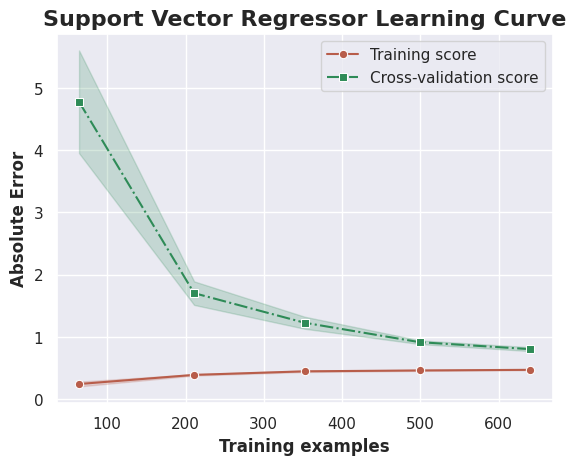

In [17]:
plt.figure()
plt.title('Support Vector Regressor Learning Curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Absolute Error', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='o', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', linestyle='-.', color=color2, label='Cross-validation score')

plt.legend(loc='upper right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Test of the model

In [22]:
i = 0
final_model = []

for train_index, test_index in cv.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    i = i + 1

    # Generate 5 possible splits and for each one save a model
    pipeline_ = Pipeline([
        ('scaler', RobustScaler()),
        ('svr', MultiOutputRegressor(svm.SVR(**best_params_cleaned)) )
    ])

    # Save a different model for each fold to make an ensemble one
    final_model.append(pipeline_.fit(X_train_1, y_train_1))

In [23]:
y_pred_ensemble = np.zeros_like(y_test)

for model in final_model:
    y_pred = model.predict(X_test)
    y_pred_ensemble += y_pred

y_pred_ensemble /= len(final_model)

mee_ensemble = mean_euclidean_error(y_test, y_pred_ensemble)
r2_ensemble = multidim_r2(y_test, y_pred_ensemble)
rmse_ensemble = root_mean_squared_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

print('Ensemble MEE:', mee_ensemble)
print('Ensemble R2:', r2_ensemble)
print('Ensemble RMSE:', rmse_ensemble)
print('Ensemble MSE:', mse_ensemble)

Ensemble MEE: 0.8133348067509973
Ensemble R2: 0.9983092218114482
Ensemble RMSE: 0.7056264609606286
Ensemble MSE: 0.4979087024078216


# Ensemble of the final model using the whole dataset

In [24]:
i = 0
final_model_ = []

for train_index, test_index in cv.split(X):
    X_train_1, X_test_1 = X[train_index], X[test_index]
    y_train_1, y_test_1 = y[train_index], y[test_index]
    i = i + 1

    # Generate 5 possible splits and for each one save a model
    pipeline_test = Pipeline([
        ('scaler', RobustScaler()),
        ('svr', MultiOutputRegressor(svm.SVR(**best_params_cleaned)) )
    ])

    # Save a different model for each fold to make an ensemble one
    final_model_.append(pipeline_test.fit(X_train_1, y_train_1))

# Save model

In [25]:
model_path = os.path.join(MODEL_FOLDER, 'SVR_model.joblib')
dump(final_model, model_path, compress=3)

model_path = os.path.join(MODEL_FOLDER, 'SVR_model_final.joblib')
dump(final_model, model_path, compress=3)

['/content/drive/My Drive/machine-learning-project/trained_models/cup2023/SVR_model_final.joblib']